In [1]:
from fastai.vision.all import *
from fastai.learner import *
from fastai.data.all import *
from fastai.callback.tracker import SaveModelCallback
import pandas as pd
import matplotlib.pyplot as plt
from pathlib2 import Path
import numpy as np
import random
from torch.nn import MSELoss

You can download the ebooks [here](https://www.openslr.org/resources/12/original-books.tar.gz).

We will need the pretrained embeddings from https://github.com/iamyuanchung/speech2vec-pretrained-vectors. We will use them to compare our results and also to figure out what vocab the authors of the speech2vec paper used for training. Let us start with the latter.

In [2]:
df_train = pd.read_csv('data/wikitext-103/train.csv', header=None)

In [3]:
df_train.shape

(29539, 1)

In [4]:
texts = df_train[0].tolist()
texts = texts[:2000]

In [5]:
import logging
from six import iteritems
from web.datasets.similarity import fetch_MEN, fetch_WS353, fetch_SimLex999
from web.embeddings import fetch_GloVe
from web.evaluate import evaluate_similarity
from web.embedding import Embedding, Vocabulary
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [6]:
speech2vec = KeyedVectors.load_word2vec_format('../speech2vec-pretrained-vectors/speech2vec/50.vec', binary=False) 

vocab = set(speech2vec.vocab.keys())
len(vocab)

37622

In [7]:
from joblib import Parallel, delayed
from functools import partial
from spacy.util import minibatch
import spacy

nlp = spacy.load("en_core_web_sm")

batch_size= 200
partitions = minibatch(texts, size=batch_size)

executor = Parallel(n_jobs=10, backend="multiprocessing", prefer="threads")

def transform_texts(nlp, vocab, text):
    docs = nlp.tokenizer.pipe(texts)
    word_pairs = []
    
    for doc in docs:
        words = [token.text.lower() for token in doc if token.is_alpha]
        words = [w if w in vocab else '<UNK>' for w in words]
        
        for i, word in enumerate(words):
            if word == '<UNK>': continue
            for offset in [-2, -1, 1, 2]:
                if i + offset < 0 or i + offset >= len(words): continue
                target_word = words[i+offset]
                if target_word == '<UNK>': continue
                word_pairs.append([word, target_word])
                 
    return word_pairs

In [8]:
# for doc in docs:
#     words = [token.text.lower() for token in doc if token.is_alpha]
#     words = [w if w in vocab else '<UNK>' for w in words]
    
#     for i, word in enumerate(words):
#         if word == '<UNK>': continue
#         for offset in [-2, -1, 1, 2]:
#             if i + offset < 0 or i + offset >= len(words): continue
#             target_word = words[i+offset]
#             if target_word == '<UNK>': continue
#             word_pairs.append([word, target_word])

In [9]:
%%time

do = delayed(partial(transform_texts, nlp, vocab))
tasks = (do(batch) for batch in partitions)
word_pairs_hierarchical = executor(tasks)

CPU times: user 1min 55s, sys: 17.7 s, total: 2min 12s
Wall time: 4min


In [10]:
word_pairs = []

for pairs in word_pairs_hierarchical: word_pairs += pairs

In [11]:
word_pairs[:10]

[['is', 'a'],
 ['a', 'is'],
 ['a', 'genus'],
 ['genus', 'a'],
 ['genus', 'in'],
 ['genus', 'the'],
 ['in', 'genus'],
 ['in', 'the'],
 ['in', 'family'],
 ['the', 'genus']]

In [12]:
# np.random.shuffle(word_pairs)

In [13]:
len(word_pairs)

183690620

In [14]:
word_pairs[:20]

[['is', 'a'],
 ['a', 'is'],
 ['a', 'genus'],
 ['genus', 'a'],
 ['genus', 'in'],
 ['genus', 'the'],
 ['in', 'genus'],
 ['in', 'the'],
 ['in', 'family'],
 ['the', 'genus'],
 ['the', 'in'],
 ['the', 'family'],
 ['family', 'in'],
 ['family', 'the'],
 ['family', 'a'],
 ['a', 'family'],
 ['a', 'grouping'],
 ['a', 'of'],
 ['grouping', 'a'],
 ['grouping', 'of']]

In [15]:
vocab = list(vocab)
word2index = {w: i for i, w in enumerate(vocab)}

In [16]:
class Dataset():
    def __init__(self, pairs, length=10_000_000):
        self.pairs = pairs
        self.len = length
    def __len__(self):
        return self.len
    def __getitem__(self, idx):
        source_word, target_word = self.pairs[np.random.randint(len(self.pairs))]
        return word2index[source_word], word2index[target_word]

In [17]:
# 14 mln -> 180 mln

In [18]:
len(word_pairs)

183690620

In [19]:
train_ds = Dataset(word_pairs)
valid_ds = Dataset(word_pairs, 200_000)

In [20]:
len(train_ds), len(valid_ds)

(10000000, 200000)

In [21]:
BS = 2048
NUM_WORKERS = 4

train_dl = DataLoader(train_ds, BS, NUM_WORKERS, shuffle=True)
valid_dl = DataLoader(valid_ds, BS, NUM_WORKERS)

dls = DataLoaders(train_dl, valid_dl)

In [22]:
class Model(Module):
    def __init__(self, hidden_size=50):
        self.embeddings =nn.Embedding(len(vocab), hidden_size)
        self.linear = nn.Linear(hidden_size, len(vocab))
            
    def forward(self, x):
        x = self.embeddings(x)
        return self.linear(x)

In [23]:
learn = Learner(
    dls.cuda(),
    Model().cuda(),
    loss_func=CrossEntropyLossFlat(),
    opt_func=Adam,
    metrics=[accuracy]
)

In [24]:
NUM_EPOCHS = 600
learn.fit(NUM_EPOCHS, lr=1e-3, cbs=SaveModelCallback(fname='text_embeddings', every_epoch=True))

epoch,train_loss,valid_loss,accuracy,time
0,6.911878,6.903167,0.094245,01:25
1,6.826917,6.809525,0.096670,01:14
2,6.772814,6.776364,0.098515,01:14
3,6.748465,6.748441,0.098995,01:14
4,6.708656,6.715177,0.099920,01:14
5,6.700110,6.692660,0.101150,01:14
6,6.670153,6.671999,0.100795,01:15
7,6.677501,6.669620,0.100570,01:14
8,6.644104,6.657688,0.100420,01:14
9,6.638129,6.638594,0.101415,01:15


In [ ]:
NUM_EPOCHS = 200
learn.fit(NUM_EPOCHS, lr=1e-4, cbs=SaveModelCallback(fname='text_embeddings_2', every_epoch=True))

## Evalute embeddings

In [25]:
from utils import Embeddings

In [26]:
embeddings = learn.model.embeddings.weight.cpu().detach().numpy()

In [27]:
e = Embeddings(
    embeddings,
    vocab
)

In [28]:
for w in ['fast', 'lost', 'small', 'true', 'crazy', 'slow']:
    print(f'{w}: {e.nn_words_to(e[w])}')

fast: ['fast', 'paced', 'slow', 'clumsily', 'forwarding']
lost: ['lost', 'losing', 'missed', 'regained', 'scored']
small: ['small', 'large', 'smaller', 'remote', 'miniature']
true: ['true', 'surprising', 'symbolic', 'bridegroom', 'believer']
crazy: ['crazy', 'hopeful', 'dangerously', 'horribly', 'immaculately']
slow: ['slow', 'tame', 'tough', 'fast', 'mood']


## Evaluating embeddings using [word-embeddings-benchmarks](https://github.com/kudkudak/word-embeddings-benchmarks)

In [29]:
import logging
from six import iteritems
from web.datasets.similarity import fetch_MEN, fetch_WS353, fetch_SimLex999
from web.embeddings import fetch_GloVe
from web.evaluate import evaluate_similarity
from web.embedding import Embedding, Vocabulary
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [30]:
tasks = {
    "MEN": fetch_MEN(),
    "WS353": fetch_WS353(),
    "SIMLEX999": fetch_SimLex999()
}

In [31]:
our_embeddings = Embedding(
    Vocabulary(vocab),
    embeddings
)

speech2vec = KeyedVectors.load_word2vec_format('../speech2vec-pretrained-vectors/word2vec/50.vec', binary=False) 
speech2vec_embeddings = Embedding(Vocabulary(list(speech2vec.vocab.keys())), speech2vec.vectors)

In [32]:
for name, data in iteritems(tasks):
    print("Spearman correlation of scores on {} {}".format(name, evaluate_similarity(our_embeddings, data.X, data.y)))

Missing 392 words. Will replace them with mean vector
/opt/conda/lib/python3.7/site-packages/web-0.0.1-py3.7.egg/web/evaluate.py:336: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  A = np.vstack(w.get(word, mean_vector) for word in X[:, 0])
/opt/conda/lib/python3.7/site-packages/web-0.0.1-py3.7.egg/web/evaluate.py:337: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  B = np.vstack(w.get(word, mean_vector) for word in X[:, 1])
Missing 61 words. Will replace them with mean vector
Missing 24 words. Will replace them with mean vector


Spearman correlation of scores on MEN 0.38720472306719
Spearman correlation of scores on WS353 0.42593220452566005
Spearman correlation of scores on SIMLEX999 0.1798777763845928


In [33]:
for name, data in iteritems(tasks):
    print("Spearman correlation of scores on {} {}".format(name, evaluate_similarity(speech2vec_embeddings, data.X, data.y)))

Missing 392 words. Will replace them with mean vector
Missing 61 words. Will replace them with mean vector
Missing 24 words. Will replace them with mean vector


Spearman correlation of scores on MEN 0.6056592803599269
Spearman correlation of scores on WS353 0.43349390636024643
Spearman correlation of scores on SIMLEX999 0.25938770901422736


## Loss decrease and improvements on semantic tasks as training progresses

In [34]:
%%capture

val_losses, accuracies, task_perf = [], [], []
for i in range(NUM_EPOCHS):
    learn.load(f'text_embeddings_{i}')
    loss, accuracy = learn.validate()
    val_losses.append(loss)
    accuracies.append(accuracy)
    
    embeddings = learn.model.embeddings.weight.cpu().detach().numpy()
    our_embeddings = Embedding(
        Vocabulary([w.lower() for w in vocab]),
        embeddings
    )

    task_perf.append([evaluate_similarity(our_embeddings, data.X, data.y) for name, data in iteritems(tasks)])

In [35]:
men, ws353, simlex999 = list(zip(*task_perf))

In [36]:
import matplotlib.pyplot as plt

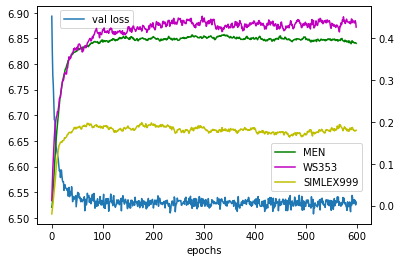

In [37]:
fig, ax1 = plt.subplots()

ax1.plot(val_losses, label='val loss')

ax2 = ax1.twinx()
ax2.plot(men, label='MEN', c='g')
ax2.plot(ws353, label='WS353', c='m')
ax2.plot(simlex999, label='SIMLEX999', c='y')

ax1.legend(loc=[0.07, 0.9])
ax2.legend(loc=[0.7, 0.15])

ax1.set_xlabel('epochs');